<a href="https://colab.research.google.com/github/Krisanthi/Customer-Churn-Prediction-Model/blob/main/CM2604_Churn_Prediction_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM2604 Machine Learning Coursework
## Telco Customer Churn Prediction

**Module:** CM2604 Machine Learning  
**RGU Student ID:** 2410212  
**IIT Student ID:** 20233136  
**Student Name:** Krish  

---

### Project Overview
This project aims to predict customer churn in a telecommunications company using machine learning techniques. We implement and compare a **Decision Tree Classifier** and a **Neural Network** model.

**Dataset:** Telco Customer Churn (Kaggle)  
**Target Variable:** Churn (Yes/No - Binary Classification)

## 1. Setup and Data Loading

In [ ]:
# Install required packages
!pip install --upgrade scikit-learn imbalanced-learn -q
print("Packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 52.2 MB/s eta 0:00:00
Packages installed successfully!


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0


In [ ]:
# Upload the dataset
print("Please upload the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"File '{filename}' uploaded successfully!")

Please upload the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
File 'WA_Fn-UseC_-Telco-Customer-Churn.csv' uploaded successfully!


In [ ]:
# Load the dataset
df = pd.read_csv(filename)
data = df.copy()
print("Dataset loaded successfully!")
print(f"Dataset shape: {data.shape}")
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

Dataset loaded successfully!
Dataset shape: (7043, 21)
Number of rows: 7043
Number of columns: 21


---
## TASK 1: Exploratory Data Analysis (EDA) - 15%
---

In [ ]:
# Dataset Overview
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nShape: {data.shape[0]} rows, {data.shape[1]} columns")
print("\n--- First 5 Rows ---")
display(data.head())

DATASET OVERVIEW

Shape: 7043 rows, 21 columns

--- First 5 Rows ---


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Dataset Info
print("\n--- Dataset Information ---")
data.info()
print("\n--- Column Data Types ---")
for i, col in enumerate(data.columns, 1):
    print(f"{i}. {col} ({data[col].dtype})")


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBill

In [ ]:
# Missing Values Analysis - CRITICAL: TotalCharges detection
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)
print(f"\nTotalCharges data type (before conversion): {data['TotalCharges'].dtype}")

# Check for empty strings in TotalCharges
empty_tc = data['TotalCharges'].replace(' ', '').eq('')
print(f"Empty strings in TotalCharges: {empty_tc.sum()}")

# Convert to numeric to reveal true missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
missing_tc = data['TotalCharges'].isnull().sum()
print(f"\nAfter converting to numeric:")
print(f"Missing values in TotalCharges: {missing_tc}")
print(f"Percentage of missing: {(missing_tc / len(data)) * 100:.2f}%")

# Show rows with missing TotalCharges
print("\n--- Rows with Missing TotalCharges ---")
display(data[data['TotalCharges'].isnull()][['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']])

MISSING VALUES ANALYSIS

TotalCharges data type (before conversion): object
Empty strings in TotalCharges: 11

After converting to numeric:
Missing values in TotalCharges: 11
Percentage of missing: 0.16%

--- Rows with Missing TotalCharges ---


,customerID,tenure,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,0,52.55,NaN,No
753,3115-CZMZD,0,20.25,NaN,No
936,5709-LVOEQ,0,80.85,NaN,No
1082,4367-NUYAO,0,25.75,NaN,No
1340,1371-DWPAZ,0,56.05,NaN,No
3331,7644-OMVMY,0,19.85,NaN,No
3826,3213-VVOLG,0,25.35,NaN,No
4380,2520-SGTTA,0,20.00,NaN,No
5218,2923-ARZLG,0,19.70,NaN,No
6670,4075-WKNIU,0,73.35,NaN,No


In [ ]:
# Duplicate Checking
print("=" * 80)
print("DUPLICATE CHECKING")
print("=" * 80)
print(f"Duplicate rows: {data.duplicated().sum()}")
print(f"Duplicate customerIDs: {data['customerID'].duplicated().sum()}")

DUPLICATE CHECKING
Duplicate rows: 0
Duplicate customerIDs: 0


In [ ]:
# Numerical Features Statistics
print("=" * 80)
print("NUMERICAL FEATURES ANALYSIS")
print("=" * 80)
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("\n--- Statistical Summary ---")
display(data[numerical_cols].describe())

print("\n--- Tenure Analysis ---")
print(f"Range: {data['tenure'].min()} to {data['tenure'].max()} months")
print(f"Mean: {data['tenure'].mean():.2f} months, Median: {data['tenure'].median():.2f} months")

print("\n--- MonthlyCharges Analysis ---")
print(f"Range: ${data['MonthlyCharges'].min():.2f} to ${data['MonthlyCharges'].max():.2f}")
print(f"Mean: ${data['MonthlyCharges'].mean():.2f}")

print("\n--- TotalCharges Analysis ---")
print(f"Range: ${data['TotalCharges'].min():.2f} to ${data['TotalCharges'].max():.2f}")
print(f"Mean: ${data['TotalCharges'].mean():.2f}")

NUMERICAL FEATURES ANALYSIS

--- Statistical Summary ---


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000



--- Tenure Analysis ---
Range: 0 to 72 months
Mean: 32.37 months, Median: 29.00 months

--- MonthlyCharges Analysis ---
Range: $18.25 to $118.75
Mean: $64.76

--- TotalCharges Analysis ---
Range: $18.80 to $8684.80
Mean: $2283.30


from matplotlib import pyplot as plt
_df_0['tenure'].plot(kind='hist', bins=20, title='tenure')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MonthlyCharges'].plot(kind='hist', bins=20, title='MonthlyCharges')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['TotalCharges'].plot(kind='hist', bins=20, title='TotalCharges')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='tenure', y='MonthlyCharges', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MonthlyCharges', y='TotalCharges', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['tenure'].plot(kind='line', figsize=(8, 4), title='tenure')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['MonthlyCharges'].plot(kind='line', figsize=(8, 4), title='MonthlyCharges')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['TotalCharges'].plot(kind='line', figsize=(8, 4), title='TotalCharges')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='tenure', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='MonthlyCharges', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='TotalCharges', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Categorical Features Analysis
print("=" * 80)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 80)
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']
print(f"\nNumber of Categorical Features: {len(categorical_cols)}")

for col in categorical_cols:
    print(f"\n{col}:")
    for val, count in data[col].value_counts().items():
        print(f"  {val}: {count} ({(count/len(data))*100:.1f}%)")

CATEGORICAL FEATURES ANALYSIS

Number of Categorical Features: 16

gender:
  Male: 3555 (50.5%)
  Female: 3488 (49.5%)

SeniorCitizen:
  0: 5901 (83.8%)
  1: 1142 (16.2%)

Partner:
  No: 3641 (51.7%)
  Yes: 3402 (48.3%)

Dependents:
  No: 4933 (70.0%)
  Yes: 2110 (30.0%)

PhoneService:
  Yes: 6361 (90.3%)
  No: 682 (9.7%)

MultipleLines:
  No: 3390 (48.1%)
  Yes: 2971 (42.2%)
  No phone service: 682 (9.7%)

InternetService:
  Fiber optic: 3096 (44.0%)
  DSL: 2421 (34.4%)
  No: 1526 (21.7%)

OnlineSecurity:
  No: 3498 (49.7%)
  Yes: 2019 (28.7%)
  No internet service: 1526 (21.7%)

OnlineBackup:
  No: 3088 (43.8%)
  Yes: 2429 (34.5%)
  No internet service: 1526 (21.7%)

DeviceProtection:
  No: 3095 (43.9%)
  Yes: 2422 (34.4%)
  No internet service: 1526 (21.7%)

TechSupport:
  No: 3473 (49.3%)
  Yes: 2044 (29.0%)
  No internet service: 1526 (21.7%)

StreamingTV:
  No: 2810 (39.9%)
  Yes: 2707 (38.4%)
  No internet service: 1526 (21.7%)

StreamingMovies:
  No: 2785 (39.5%)
  Yes: 2732 (3

In [ ]:
# Target Variable Analysis
print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)
target_counts = data['Churn'].value_counts()
target_pct = data['Churn'].value_counts(normalize=True) * 100

print(f"\nNo (Did not churn): {target_counts['No']} ({target_pct['No']:.2f}%)")
print(f"Yes (Churned): {target_counts['Yes']} ({target_pct['Yes']:.2f}%)")
print(f"\nClass Imbalance Ratio: {target_counts['No'] / target_counts['Yes']:.2f}:1")
print("\n** Dataset exhibits class imbalance requiring SMOTE balancing **")

TARGET VARIABLE ANALYSIS

No (Did not churn): 5174 (73.46%)
Yes (Churned): 1869 (26.54%)

Class Imbalance Ratio: 2.77:1

** Dataset exhibits class imbalance requiring SMOTE balancing **


---
## Data Visualizations
---

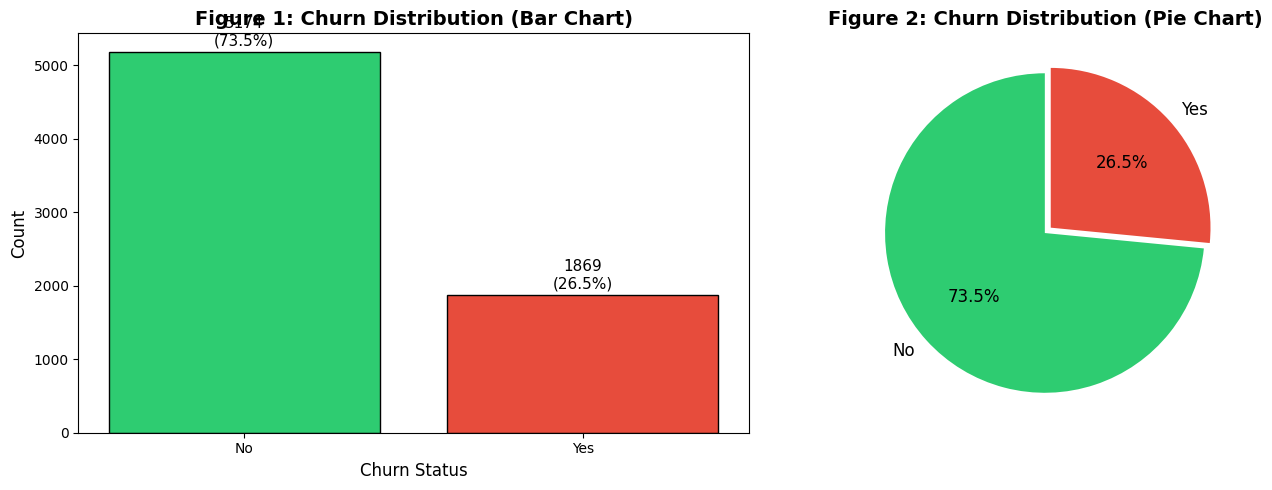

Figures 1 & 2 saved!


In [ ]:
# Figure 1 & 2: Churn Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#2ecc71', '#e74c3c']

# Bar Chart
bars = axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Churn Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Figure 1: Churn Distribution (Bar Chart)', fontsize=14, fontweight='bold')
for bar, count, pct in zip(bars, target_counts.values, target_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

# Pie Chart
axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0, 0.05], startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Figure 2: Churn Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('fig1_2_churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figures 1 & 2 saved!")

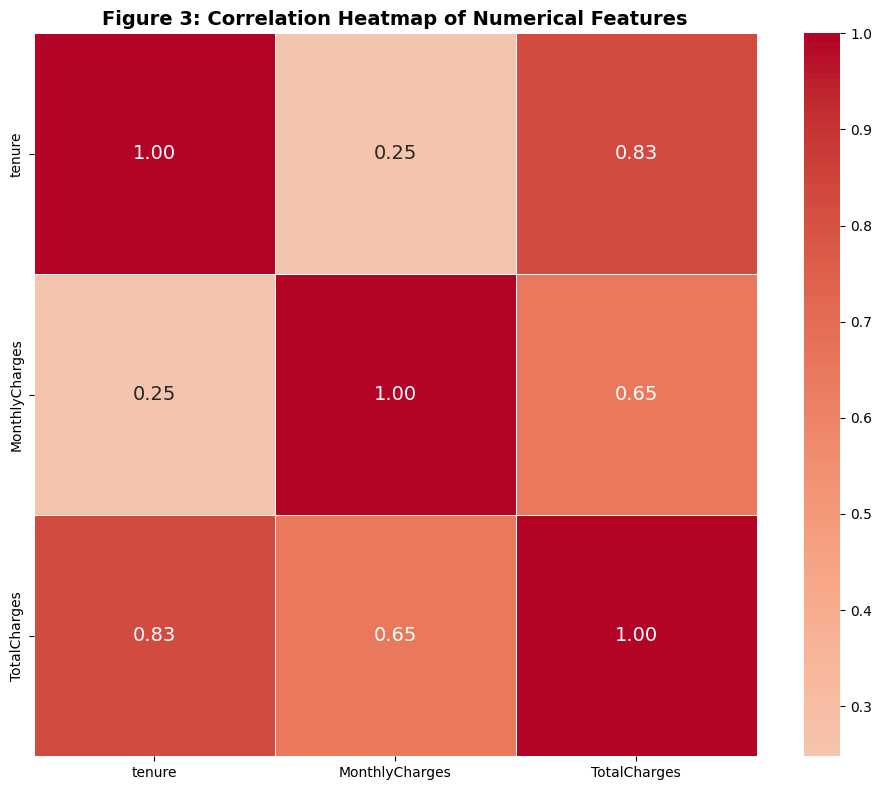

Figure 3 saved!
Tenure-TotalCharges correlation: 0.826


In [ ]:
# Figure 3: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=0.5, annot_kws={'size': 14})
plt.title('Figure 3: Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig3_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 3 saved!")
print(f"Tenure-TotalCharges correlation: {corr_matrix.loc['tenure', 'TotalCharges']:.3f}")

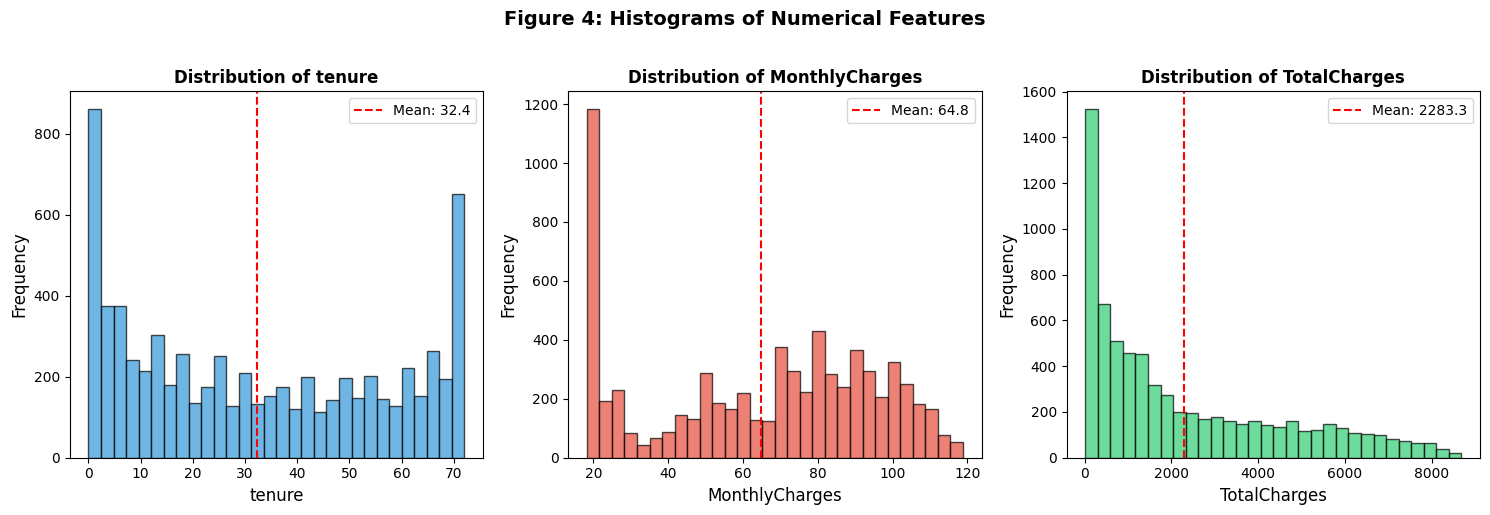

Figure 4 saved!


In [ ]:
# Figure 4: Histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (col, ax, color) in enumerate(zip(numerical_cols, axes, colors)):
    ax.hist(data[col].dropna(), bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(data[col].mean(), color='red', linestyle='--', label=f'Mean: {data[col].mean():.1f}')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.legend()

plt.suptitle('Figure 4: Histograms of Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig4_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4 saved!")

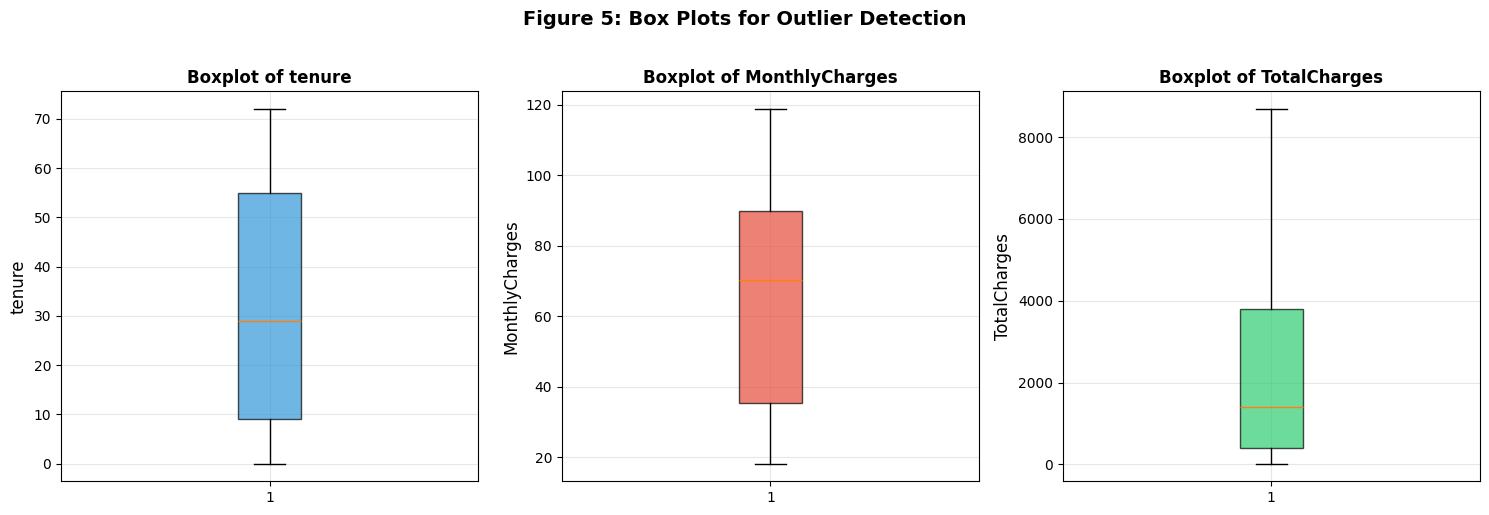

Figure 5 saved!


In [ ]:
# Figure 5: Box Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (col, ax, color) in enumerate(zip(numerical_cols, axes, colors)):
    bp = ax.boxplot(data[col].dropna(), patch_artist=True)
    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][0].set_alpha(0.7)
    ax.set_ylabel(col, fontsize=12)
    ax.set_title(f'Boxplot of {col}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Figure 5: Box Plots for Outlier Detection', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig5_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 5 saved!")

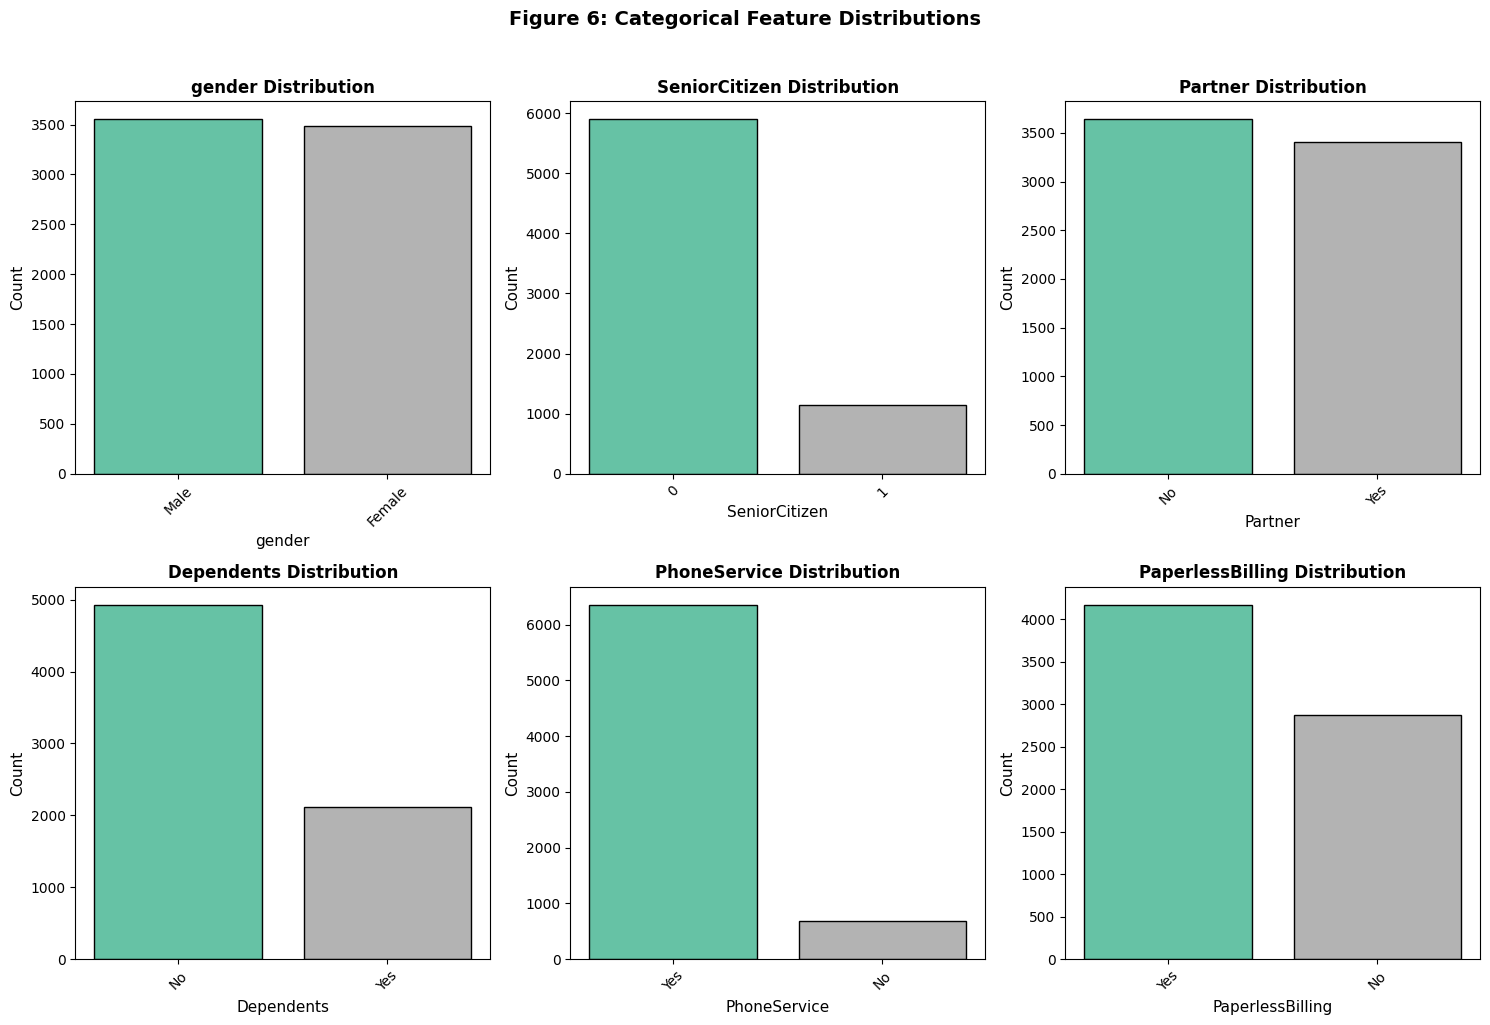

Figure 6 saved!


In [ ]:
# Figure 6: Categorical Feature Distributions
key_cats = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(key_cats):
    vc = data[col].value_counts()
    colors_list = plt.cm.Set2(np.linspace(0, 1, len(vc)))
    bars = axes[i].bar(vc.index.astype(str), vc.values, color=colors_list, edgecolor='black')
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel('Count', fontsize=11)
    axes[i].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Figure 6: Categorical Feature Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig6_categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 6 saved!")

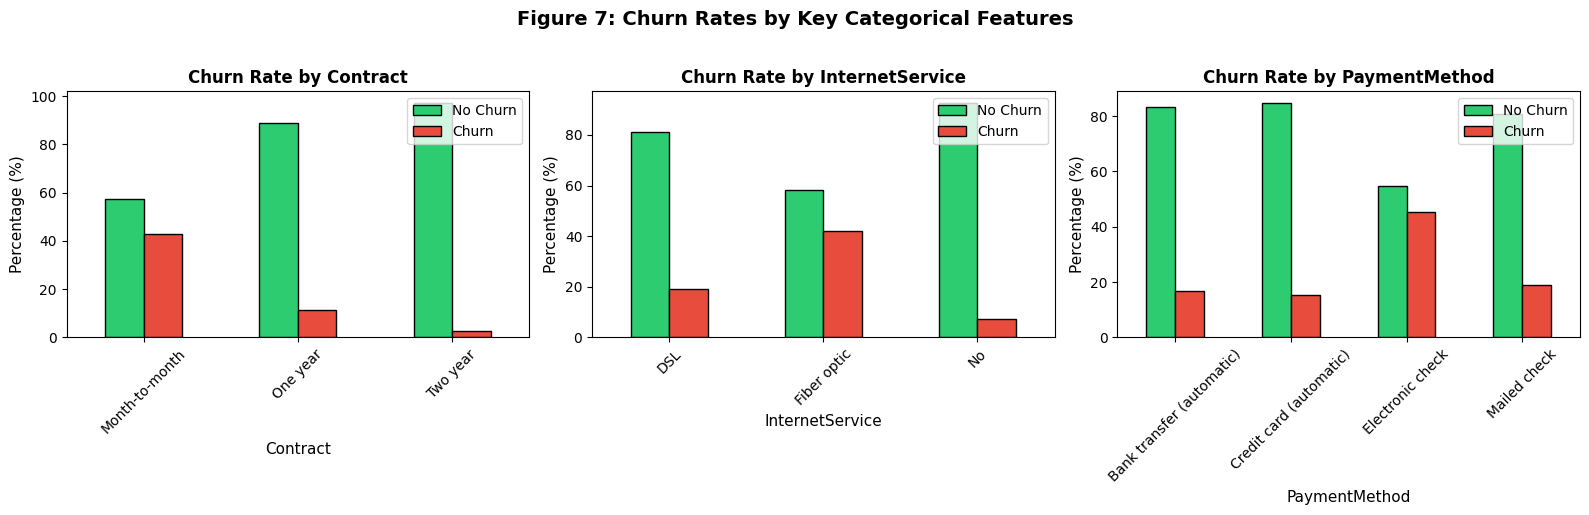

Figure 7 saved!


In [ ]:
# Figure 7: Churn by Contract, InternetService, PaymentMethod
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col in zip(axes, ['Contract', 'InternetService', 'PaymentMethod']):
    ct = pd.crosstab(data[col], data['Churn'], normalize='index') * 100
    ct.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], edgecolor='black')
    ax.set_title(f'Churn Rate by {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Percentage (%)', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(['No Churn', 'Churn'], loc='upper right')

plt.suptitle('Figure 7: Churn Rates by Key Categorical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig7_churn_by_categories.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 7 saved!")

---
## TASK 2A: Corpus Preparation - 25%
---

In [ ]:
# Reload data for preprocessing
data = df.copy()
print("=" * 80)
print("CORPUS PREPARATION")
print("=" * 80)
print(f"\nInitial dataset shape: {data.shape}")

# Step 1: Convert TotalCharges to numeric
print("\n--- Step 1: Convert TotalCharges to Numeric ---")
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(f"Missing values revealed: {data['TotalCharges'].isnull().sum()}")

# Step 2: Impute missing values with median
print("\n--- Step 2: Impute Missing Values with Median ---")
median_val = data['TotalCharges'].median()
data['TotalCharges'].fillna(median_val, inplace=True)
print(f"Median used for imputation: ${median_val:.2f}")
print(f"Missing values after imputation: {data['TotalCharges'].isnull().sum()}")

# Step 3: Check and remove duplicates
print("\n--- Step 3: Check and Remove Duplicates ---")
print(f"Duplicate rows: {data.duplicated().sum()}")
data.drop_duplicates(inplace=True)

# Step 4: Remove customerID
print("\n--- Step 4: Remove customerID Column ---")
data.drop(columns=['customerID'], inplace=True)
print(f"customerID removed. Shape: {data.shape}")

CORPUS PREPARATION

Initial dataset shape: (7043, 21)

--- Step 1: Convert TotalCharges to Numeric ---
Missing values revealed: 11

--- Step 2: Impute Missing Values with Median ---
Median used for imputation: $1397.47
Missing values after imputation: 0

--- Step 3: Check and Remove Duplicates ---
Duplicate rows: 0

--- Step 4: Remove customerID Column ---
customerID removed. Shape: (7043, 20)


In [ ]:
# Step 5: Binary encoding
print("\n--- Step 5: Binary Encoding ---")
binary_maps = {
    'gender': {'Male': 1, 'Female': 0},
    'Partner': {'Yes': 1, 'No': 0},
    'Dependents': {'Yes': 1, 'No': 0},
    'PhoneService': {'Yes': 1, 'No': 0},
    'PaperlessBilling': {'Yes': 1, 'No': 0},
    'Churn': {'Yes': 1, 'No': 0}
}
for col, mapping in binary_maps.items():
    data[col] = data[col].map(mapping)
    print(f"{col}: {mapping}")

# Step 6: One-hot encoding
print("\n--- Step 6: One-Hot Encoding ---")
onehot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaymentMethod']
print(f"Columns before: {len(data.columns)}")
data = pd.get_dummies(data, columns=onehot_cols, drop_first=True)
print(f"Columns after: {len(data.columns)}")


--- Step 5: Binary Encoding ---
gender: {'Male': 1, 'Female': 0}
Partner: {'Yes': 1, 'No': 0}
Dependents: {'Yes': 1, 'No': 0}
PhoneService: {'Yes': 1, 'No': 0}
PaperlessBilling: {'Yes': 1, 'No': 0}
Churn: {'Yes': 1, 'No': 0}

--- Step 6: One-Hot Encoding ---
Columns before: 20
Columns after: 31


In [ ]:
# Step 7: Outlier removal
print("\n--- Step 7: Outlier Removal (Z-score > 3) ---")
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(f"Rows before: {len(data)}")
z_scores = np.abs(zscore(data[numerical_features]))
data = data[(z_scores < 3).all(axis=1)]
print(f"Rows after: {len(data)}")

# Step 8: Feature scaling
print("\n--- Step 8: Feature Scaling (StandardScaler) ---")
X = data.drop(columns=['Churn'])
y = data['Churn']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
print("Numerical features scaled (mean=0, std=1)")

# Step 9: SMOTE
print("\n--- Step 9: SMOTE for Class Balancing ---")
print(f"Before SMOTE: {y.value_counts().to_dict()}")
smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)
print(f"After SMOTE: {pd.Series(y_balanced).value_counts().to_dict()}")

# Step 10: Train-test split
print("\n--- Step 10: Train-Test Split (80-20, Stratified) ---")
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.20,
                                                    random_state=42, stratify=y_balanced)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print("\n" + "=" * 80)
print("CORPUS PREPARATION COMPLETE!")
print("=" * 80)


--- Step 7: Outlier Removal (Z-score > 3) ---
Rows before: 7043
Rows after: 7043

--- Step 8: Feature Scaling (StandardScaler) ---
Numerical features scaled (mean=0, std=1)

--- Step 9: SMOTE for Class Balancing ---
Before SMOTE: {0: 5174, 1: 1869}
After SMOTE: {0: 5174, 1: 5174}

--- Step 10: Train-Test Split (80-20, Stratified) ---
X_train: (8278, 30), X_test: (2070, 30)
y_train: (8278,), y_test: (2070,)

CORPUS PREPARATION COMPLETE!


---
## TASK 2B: Model Implementation - 25%
---

In [ ]:
# Decision Tree with GridSearchCV
print("=" * 80)
print("DECISION TREE CLASSIFIER WITH GRIDSEARCHCV")
print("=" * 80)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
print(f"\nParameter combinations: {2*5*3*3*3}")
print("Running GridSearchCV with 5-fold CV...")

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("\n--- Best Parameters ---")
for param, val in grid_search.best_params_.items():
    print(f"  {param}: {val}")
print(f"\nBest CV F1-Score: {grid_search.best_score_:.4f}")

DECISION TREE CLASSIFIER WITH GRIDSEARCHCV

Parameter combinations: 270
Running GridSearchCV with 5-fold CV...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits

--- Best Parameters ---
  criterion: gini
  max_depth: 10
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 5

Best CV F1-Score: 0.7967


In [ ]:
# Decision Tree Evaluation
best_dt = grid_search.best_estimator_
dt_train_pred = best_dt.predict(X_train)
dt_test_pred = best_dt.predict(X_test)
dt_test_proba = best_dt.predict_proba(X_test)[:, 1]

print("=" * 80)
print("DECISION TREE EVALUATION RESULTS")
print("=" * 80)

dt_accuracy = accuracy_score(y_test, dt_test_pred)
dt_precision = precision_score(y_test, dt_test_pred)
dt_recall = recall_score(y_test, dt_test_pred)
dt_f1 = f1_score(y_test, dt_test_pred)
dt_roc_auc = roc_auc_score(y_test, dt_test_proba)

print(f"\nTest Metrics:")
print(f"  Accuracy: {dt_accuracy:.4f}")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall: {dt_recall:.4f}")
print(f"  F1-Score: {dt_f1:.4f}")
print(f"  ROC-AUC: {dt_roc_auc:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, dt_test_pred, target_names=['No Churn', 'Churn']))

DECISION TREE EVALUATION RESULTS

Test Metrics:
  Accuracy: 0.7850
  Precision: 0.7620
  Recall: 0.8290
  F1-Score: 0.7941
  ROC-AUC: 0.8434

--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.81      0.74      0.78      1035
       Churn       0.76      0.83      0.79      1035

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.78      2070
weighted avg       0.79      0.79      0.78      2070



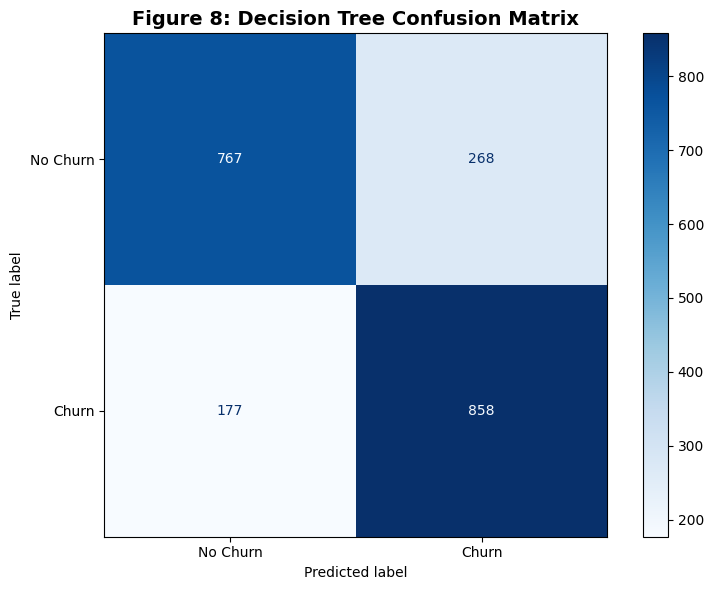

Figure 8 saved!

TN: 767, FP: 268, FN: 177, TP: 858


In [ ]:
# Figure 8: Decision Tree Confusion Matrix
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(y_test, dt_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Figure 8: Decision Tree Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig8_dt_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 8 saved!")

tn, fp, fn, tp = cm_dt.ravel()
print(f"\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


--- Decision Tree Feature Importance (Top 10) ---


,Feature,Importance
26,Contract_Two year,0.247936
4,tenure,0.153489
25,Contract_One year,0.145769
7,MonthlyCharges,0.095207
11,InternetService_Fiber optic,0.085784
8,TotalCharges,0.055982
24,StreamingMovies_Yes,0.034824
28,PaymentMethod_Electronic check,0.033828
22,StreamingTV_Yes,0.018796
10,MultipleLines_Yes,0.017134


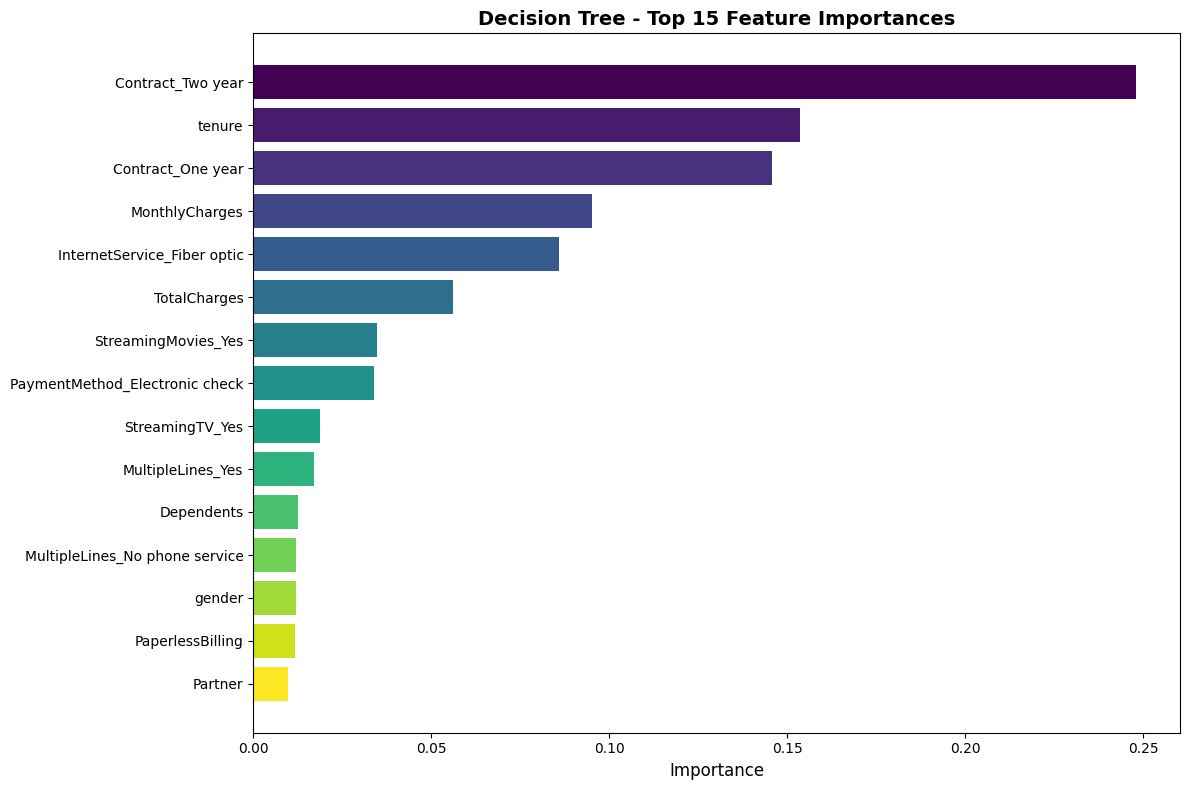

In [ ]:
# Feature Importance
print("\n--- Decision Tree Feature Importance (Top 10) ---")
feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_dt.feature_importances_})
feat_imp = feat_imp.sort_values('Importance', ascending=False)
display(feat_imp.head(10))

plt.figure(figsize=(12, 8))
top15 = feat_imp.head(15)
plt.barh(top15['Feature'], top15['Importance'], color=plt.cm.viridis(np.linspace(0, 1, 15)))
plt.xlabel('Importance', fontsize=12)
plt.title('Decision Tree - Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('dt_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Neural Network Model
print("=" * 80)
print("NEURAL NETWORK MODEL")
print("=" * 80)
print("\nArchitecture: Input -> 128 -> 64 -> 32 -> 16 -> 1")
print("Dropout: 0.3, 0.3, 0.2")
print("Optimizer: Adam, Loss: Binary Crossentropy")

nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.summary()

NEURAL NETWORK MODEL

Architecture: Input -> 128 -> 64 -> 32 -> 16 -> 1
Dropout: 0.3, 0.3, 0.2
Optimizer: Adam, Loss: Binary Crossentropy


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Neural Network
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

print("\nTraining Neural Network...")
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32,
                       validation_split=0.2, callbacks=[early_stop], verbose=1)
print("Training complete!")


Training Neural Network...
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6774 - loss: 0.5994 - val_accuracy: 0.7645 - val_loss: 0.4938
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7655 - loss: 0.4926 - val_accuracy: 0.7675 - val_loss: 0.4861
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7756 - loss: 0.4850 - val_accuracy: 0.7717 - val_loss: 0.4845
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7670 - loss: 0.4848 - val_accuracy: 0.7729 - val_loss: 0.4816
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7642 - loss: 0.4792 - val_accuracy: 0.7687 - val_loss: 0.4786
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7802 - loss: 0.4671 - val_accuracy: 0.7693 - val_loss: 0.4785
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7740 - loss: 0.4686 - val_accuracy: 0.7723 - val_loss: 0.4763
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.77

In [ ]:
# Neural Network Evaluation
nn_test_proba = nn_model.predict(X_test).ravel()
nn_test_pred = (nn_test_proba >= 0.5).astype(int)

print("=" * 80)
print("NEURAL NETWORK EVALUATION RESULTS")
print("=" * 80)

nn_accuracy = accuracy_score(y_test, nn_test_pred)
nn_precision = precision_score(y_test, nn_test_pred)
nn_recall = recall_score(y_test, nn_test_pred)
nn_f1 = f1_score(y_test, nn_test_pred)
nn_roc_auc = roc_auc_score(y_test, nn_test_proba)

print(f"\nTest Metrics:")
print(f"  Accuracy: {nn_accuracy:.4f}")
print(f"  Precision: {nn_precision:.4f}")
print(f"  Recall: {nn_recall:.4f}")
print(f"  F1-Score: {nn_f1:.4f}")
print(f"  ROC-AUC: {nn_roc_auc:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, nn_test_pred, target_names=['No Churn', 'Churn']))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NEURAL NETWORK EVALUATION RESULTS

Test Metrics:
  Accuracy: 0.8058
  Precision: 0.7849
  Recall: 0.8425
  F1-Score: 0.8127
  ROC-AUC: 0.8823

--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.83      0.77      0.80      1035
       Churn       0.78      0.84      0.81      1035

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



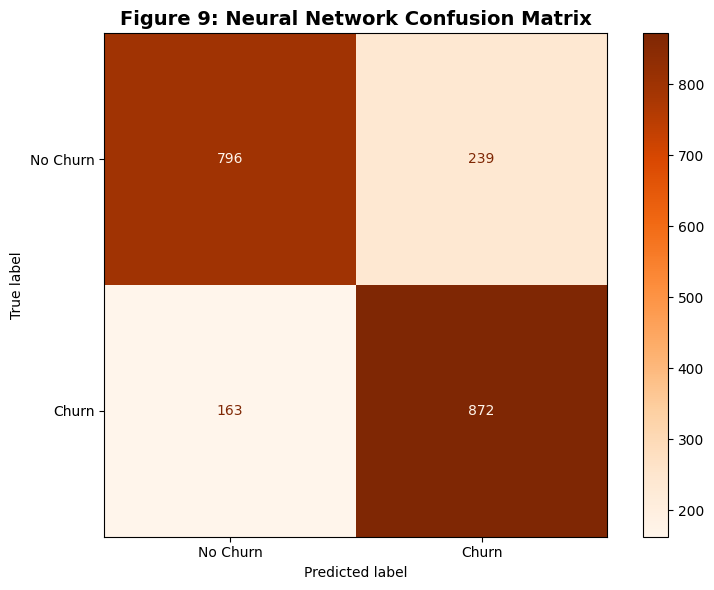

Figure 9 saved!


In [ ]:
# Figure 9: Neural Network Confusion Matrix
plt.figure(figsize=(8, 6))
cm_nn = confusion_matrix(y_test, nn_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Oranges', ax=plt.gca())
plt.title('Figure 9: Neural Network Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig9_nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 9 saved!")

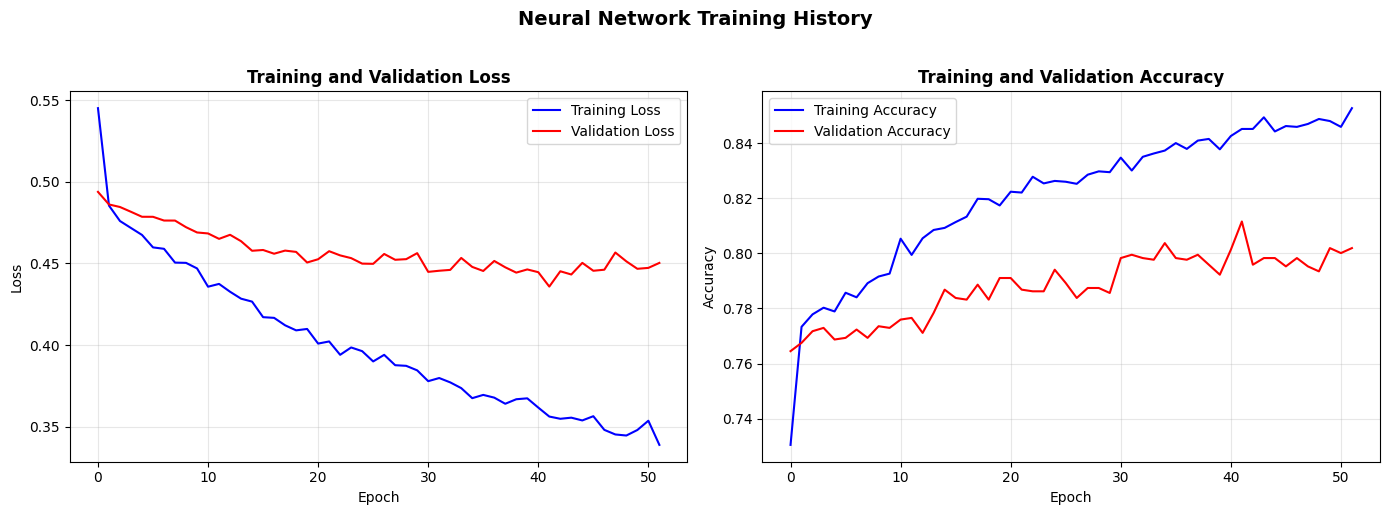

In [ ]:
# Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle('Neural Network Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

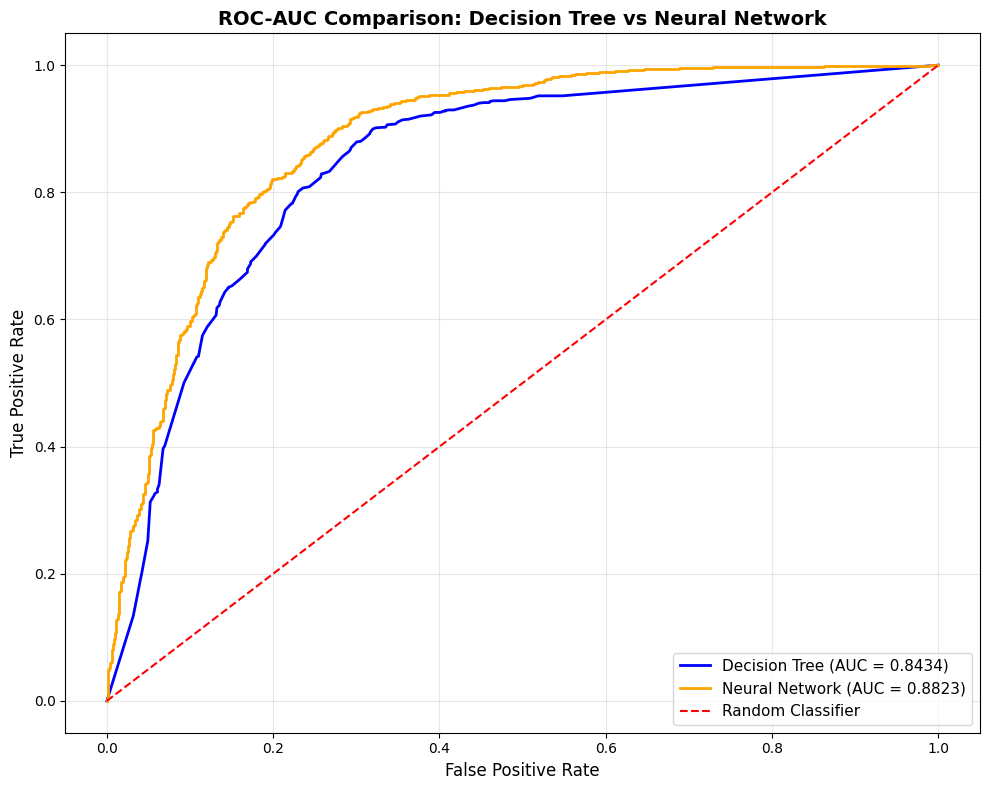

ROC-AUC comparison saved!


In [ ]:
# ROC-AUC Comparison
plt.figure(figsize=(10, 8))
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_test_proba)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_test_proba)

plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_roc_auc:.4f})', color='blue', linewidth=2)
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_roc_auc:.4f})', color='orange', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier', linewidth=1.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-AUC Comparison: Decision Tree vs Neural Network', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC-AUC comparison saved!")

In [ ]:
# Model Comparison
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Decision Tree': [dt_accuracy, dt_precision, dt_recall, dt_f1, dt_roc_auc],
    'Neural Network': [nn_accuracy, nn_precision, nn_recall, nn_f1, nn_roc_auc]
})
comparison['Difference'] = comparison['Neural Network'] - comparison['Decision Tree']
display(comparison)

f1_improvement = ((nn_f1 - dt_f1) / dt_f1) * 100
print(f"\n** Neural Network achieves {f1_improvement:.1f}% higher F1-score **")
print("** RECOMMENDATION: Neural Network is the better performing model **")

MODEL COMPARISON


,Metric,Decision Tree,Neural Network,Difference
0,Accuracy,0.785024,0.805797,0.020773
1,Precision,0.761989,0.784878,0.022889
2,Recall,0.828986,0.842512,0.013527
3,F1-Score,0.794077,0.812675,0.018598
4,ROC-AUC,0.843425,0.882294,0.038869



** Neural Network achieves 2.3% higher F1-score **
** RECOMMENDATION: Neural Network is the better performing model **


from matplotlib import pyplot as plt
comparison['Decision Tree'].plot(kind='hist', bins=20, title='Decision Tree')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison['Neural Network'].plot(kind='hist', bins=20, title='Neural Network')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison['Difference'].plot(kind='hist', bins=20, title='Difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparison.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison.plot(kind='scatter', x='Decision Tree', y='Neural Network', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison.plot(kind='scatter', x='Neural Network', y='Difference', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison['Decision Tree'].plot(kind='line', figsize=(8, 4), title='Decision Tree')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison['Neural Network'].plot(kind='line', figsize=(8, 4), title='Neural Network')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison['Difference'].plot(kind='line', figsize=(8, 4), title='Difference')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison, x='Decision Tree', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison, x='Neural Network', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison, x='Difference', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

---
## TASK 3: AI Ethics - 10%
---

### Development Strategies:

**1. Data Privacy:**
- Removed customerID to eliminate PII
- No personal identifiers used in training

**2. Fairness:**
- Gender feature monitored for bias
- SMOTE applied to prevent class imbalance bias
- Feature importance analyzed

**3. Transparency:**
- Decision Tree provides interpretable results
- All preprocessing steps documented
- Clear evaluation metrics

### Post-Deployment Strategy:

**1. Monitoring:** Monthly performance tracking

**2. Bias Detection:** Quarterly fairness audits

**3. Retraining:** Quarterly updates with new data

**4. Human Oversight:** Retention team reviews predictions

In [ ]:
# Download figures
print("Downloading all figures...")
figs = ['fig1_2_churn_distribution.png', 'fig3_correlation_heatmap.png', 'fig4_histograms.png',
        'fig5_boxplots.png', 'fig6_categorical_distributions.png', 'fig7_churn_by_categories.png',
        'fig8_dt_confusion_matrix.png', 'fig9_nn_confusion_matrix.png', 'roc_auc_comparison.png']
for f in figs:
    try: files.download(f); print(f"Downloaded: {f}")
    except: print(f"Could not download: {f}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig1_2_churn_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig3_correlation_heatmap.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig4_histograms.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig5_boxplots.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig6_categorical_distributions.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig7_churn_by_categories.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig8_dt_confusion_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: fig9_nn_confusion_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: roc_auc_comparison.png


In [ ]:
print("\n" + "=" * 80)
print("CM2604 COURSEWORK COMPLETE!")
print("=" * 80)
print(f"\nDecision Tree: Accuracy={dt_accuracy:.4f}, F1={dt_f1:.4f}, AUC={dt_roc_auc:.4f}")
print(f"Neural Network: Accuracy={nn_accuracy:.4f}, F1={nn_f1:.4f}, AUC={nn_roc_auc:.4f}")
print(f"\nWINNER: Neural Network ({((nn_f1-dt_f1)/dt_f1)*100:.1f}% F1 improvement)")
print("\nGitHub Repository: [Insert your GitHub URL here]")
print("\nStudent: Krisanthi Segar")
print("RGU Student ID: 2425596")
print("IIT Student ID: 20232384")


CM2604 COURSEWORK COMPLETE!

Decision Tree: Accuracy=0.7850, F1=0.7941, AUC=0.8434
Neural Network: Accuracy=0.8058, F1=0.8127, AUC=0.8823

WINNER: Neural Network (2.3% F1 improvement)

GitHub Repository: [Insert your GitHub URL here]

Student: Krisanthi Segar
RGU Student ID: 2425596
IIT Student ID: 20232384
